In [1]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch import optim
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch

در بلاک بالا ما کتابخانه های لازم را ایمپورت کرده ایم

In [27]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2023, 0.1994, 0.2010))])
train_data = CIFAR10(root='./train/',
                     train = True,
                     download = True,
                     transform = train_transforms)
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
  (0.4914, 0.4822, 0.4465),
  (0.2023, 0.1994, 0.2010))])
test_data = CIFAR10(root = './test/',
                    train = False,
                    download = True,
                    transform = test_transforms)
data,label = train_data[0]
test_info,test_label = test_data[0]
print(data.size())
print(test_info.size())

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


در بلاک بالا ما آمده ایم و دیتاست آموزش و تست خود را لود کرده ایم. و در ادامه تغییرات خود را بر دیتاست ها اعمال کرده ایم

In [3]:
train_set, val_set = random_split(
train_data,
[40000, 10000])

trainloader = torch.utils.data.DataLoader(
train_set,
batch_size=16,
shuffle=True)

valloader = torch.utils.data.DataLoader(
val_set,
batch_size=16,
shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = 16,
    shuffle = False
)

در بلاک بالا ما آمده ایم و داده های آموزش را به دو بخش تست و اعتبار سنجی تقسیم نموده ایم سپس دیتا لودر هایی مخصوص داده های آموزش و اعتبار سنجی و تست ساخته ایم 

In [ ]:
class Cifar10CnnModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

در بلاک بالا کلاس شبکه عصبی خود را تعریف کرده ایم

In [ ]:
device = ('cuda' if torch.cuda.is_available()
else 'cpu')
model1 = Cifar10CnnModel1().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(),
lr=0.001,
momentum=0.9)

در بلاک بالا یکسری متغیر را برای فرآیند آموزش آماده کرده ایم

In [ ]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
  # Training
  train_loss = 0.0
  model1.train()
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model1(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # Validation
  val_loss = 0.0
  model1.eval()
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model1(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
  print(
  "Epoch: {} Train Loss: {} Val Loss: {}".format(
  epoch,
  train_loss/len(trainloader),
  val_loss/len(valloader)))

Epoch: 0 Train Loss: 2.301559439277649 Val Loss: 2.292481169128418
Epoch: 1 Train Loss: 2.055811110210419 Val Loss: 1.8968302799224854
Epoch: 2 Train Loss: 1.8159523661136627 Val Loss: 1.7392296382904053
Epoch: 3 Train Loss: 1.642881257224083 Val Loss: 1.5488031725883484
Epoch: 4 Train Loss: 1.507182158255577 Val Loss: 1.4678869289398193
Epoch: 5 Train Loss: 1.3739176992416382 Val Loss: 1.3765078018188477
Epoch: 6 Train Loss: 1.2477668721079826 Val Loss: 1.2433375986099242
Epoch: 7 Train Loss: 1.1355626146793365 Val Loss: 1.0774916698932648
Epoch: 8 Train Loss: 1.0380304532766342 Val Loss: 0.9955288276672364
Epoch: 9 Train Loss: 0.9609708803296089 Val Loss: 0.9478742447137832


در بلاک بالا داریم شبکه عصبی مان را آموزش میدهیم

In [ ]:
num_correct = 0.0
for x_test_batch, y_test_batch in test_loader:
  model1.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model1(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted ==
    y_test_batch).float().sum()
accuracy = num_correct/(len(test_loader) \
  *test_loader.batch_size)
print(len(test_loader), test_loader.batch_size)
# out: 625 16
print("Test Accuracy: {}".format(accuracy))
# out: Test Accuracy: 0.6322000026702881

625 16
Test Accuracy: 0.6949999928474426


در بلاک بالا داریم شبکه عصبی مان را تست میکنیم

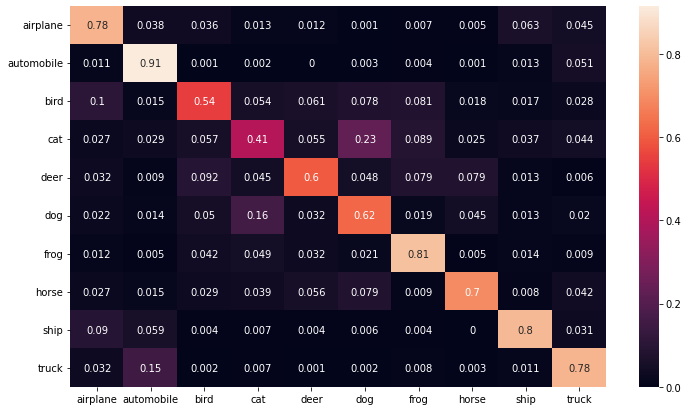

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        model1.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model1(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = test_data.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

در بلاک بالا داریم ماتریکس سردرگمی مربوط به شبکه عصبی متناظر را رسم میکنیم

In [ ]:
class Cifar10CnnModel1_with_batchnormalization(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

این همان شبکه عصبی قبلی است ولی دارای نرمالسازی بچ هست. در بلاک های بعدی این شبکه جدید را تست میکنیم

In [ ]:
device = ('cuda' if torch.cuda.is_available()
else 'cpu')
model1_with_batchnormalization = Cifar10CnnModel1_with_batchnormalization().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1_with_batchnormalization.parameters(),
lr=0.001,
momentum=0.9)

In [ ]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
  # Training
  train_loss = 0.0
  model1_with_batchnormalization.train()
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model1_with_batchnormalization(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # Validation
  val_loss = 0.0
  model1_with_batchnormalization.eval()
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model1_with_batchnormalization(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
  print(
  "Epoch: {} Train Loss: {} Val Loss: {}".format(
  epoch,
  train_loss/len(trainloader),
  val_loss/len(valloader)))

Epoch: 0 Train Loss: 0.9894135846734047 Val Loss: 0.8715740203857422
Epoch: 1 Train Loss: 0.8084203804433345 Val Loss: 0.790289669919014
Epoch: 2 Train Loss: 0.7051477024585009 Val Loss: 0.6609482508540153
Epoch: 3 Train Loss: 0.6378532159745693 Val Loss: 0.6689410465955734
Epoch: 4 Train Loss: 0.5786418708577752 Val Loss: 0.5939226829767227
Epoch: 5 Train Loss: 0.5385268989652395 Val Loss: 0.5247090649008751
Epoch: 6 Train Loss: 0.5009749232858419 Val Loss: 0.5595940680027008
Epoch: 7 Train Loss: 0.46776517180502414 Val Loss: 0.48439798299670217
Epoch: 8 Train Loss: 0.43301418068856 Val Loss: 0.4853776676803827
Epoch: 9 Train Loss: 0.41098872198611497 Val Loss: 0.47448110411167144


In [ ]:
num_correct = 0.0
for x_test_batch, y_test_batch in test_loader:
  model1_with_batchnormalization.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model1_with_batchnormalization(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted ==
    y_test_batch).float().sum()
accuracy = num_correct/(len(test_loader) \
  *test_loader.batch_size)
print(len(test_loader), test_loader.batch_size)
# out: 625 16
print("Test Accuracy: {}".format(accuracy))
# out: Test Accuracy: 0.6322000026702881

625 16
Test Accuracy: 0.8413999676704407


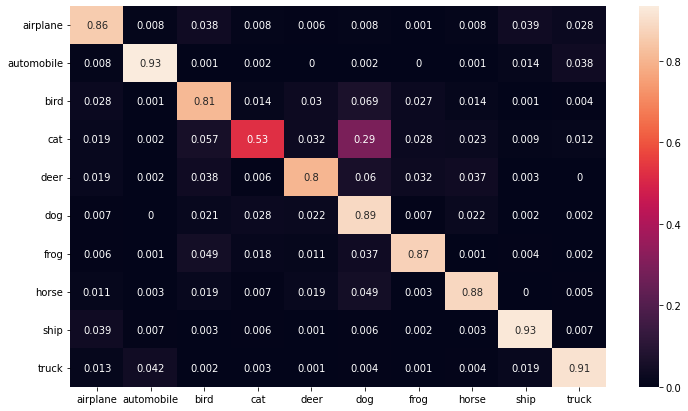

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        model1_with_batchnormalization.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model1_with_batchnormalization(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = test_data.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

در بلاک بالا ماتریکس سردر گمی مربوط به شبکه عصبی مورد نظر را رسم کرده ایم

در بلاک های پایین ما یک شبکه عصبی دیگر را طراحی وتست میکنیم و در آخر سر ماتریکس سردرگمی آن را میکشیم

In [21]:
class Cifar10CnnModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1, padding=1),
            nn.BatchNorm2d(32), # output: 32 x 34 x 34
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(64), # output: 64 x 36 x 36
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 18 x 18

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 9 x 9

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), # output: 256 x 9 x 9

            nn.Flatten(), 
            nn.Linear(256*9*9, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
device = ('cuda' if torch.cuda.is_available()
else 'cpu')
model2 = Cifar10CnnModel2().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(),
lr=0.001,
momentum=0.9)

In [23]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
  # Training
  train_loss = 0.0
  model2.train()
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # Validation
  val_loss = 0.0
  model2.eval()
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
  print(
  "Epoch: {} Train Loss: {} Val Loss: {}".format(
  epoch,
  train_loss/len(trainloader),
  val_loss/len(valloader)))

Epoch: 0 Train Loss: 1.5435877515792846 Val Loss: 1.3297079683303834
Epoch: 1 Train Loss: 1.259352043247223 Val Loss: 1.2002452776908874
Epoch: 2 Train Loss: 1.1239044690966606 Val Loss: 1.0983077772140504
Epoch: 3 Train Loss: 1.0302421460986138 Val Loss: 0.9995346566677094
Epoch: 4 Train Loss: 0.9610657755732537 Val Loss: 0.9920851133346558
Epoch: 5 Train Loss: 0.9045531239509582 Val Loss: 0.9347295258045196
Epoch: 6 Train Loss: 0.8570279255568981 Val Loss: 0.8951540526390076
Epoch: 7 Train Loss: 0.8072978241860866 Val Loss: 0.9051122289180755
Epoch: 8 Train Loss: 0.7738945495605469 Val Loss: 0.8467320307254791
Epoch: 9 Train Loss: 0.7356314645648002 Val Loss: 0.7997468272566796


In [24]:
num_correct = 0.0
for x_test_batch, y_test_batch in test_loader:
  model2.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model2(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted ==
    y_test_batch).float().sum()
accuracy = num_correct/(len(test_loader) \
  *test_loader.batch_size)
print(len(test_loader), test_loader.batch_size)
# out: 625 16
print("Test Accuracy: {}".format(accuracy))
# out: Test Accuracy: 0.6322000026702881

625 16
Test Accuracy: 0.738099992275238


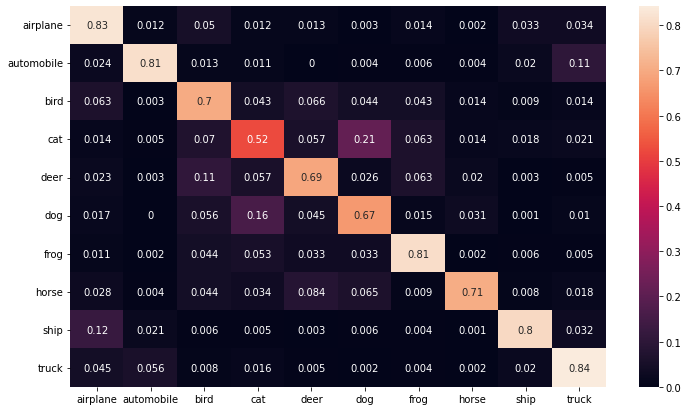

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        model2.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model2(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = test_data.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

حال در بلاک های زیرین یک شبکه عصبی دیگر را تست میکنیم

In [29]:
class Cifar10CnnModel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(32), # output: 32 x 34 x 34
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=1, stride=3, padding=3),
            nn.BatchNorm2d(64), # output: 64 x 14 x 14
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), # output: 128 x 14 x 14
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=5, padding=2),
            nn.BatchNorm2d(256), # output: 256 x 4 x 4
            nn.ReLU(),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [30]:
device = ('cuda' if torch.cuda.is_available()
else 'cpu')
model3 = Cifar10CnnModel3().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(),
lr=0.001,
momentum=0.9)

In [31]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
  # Training
  train_loss = 0.0
  model3.train()
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model3(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # Validation
  val_loss = 0.0
  model3.eval()
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model3(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
  print(
  "Epoch: {} Train Loss: {} Val Loss: {}".format(
  epoch,
  train_loss/len(trainloader),
  val_loss/len(valloader)))

Epoch: 0 Train Loss: 1.7394590826272964 Val Loss: 1.5702160342216491
Epoch: 1 Train Loss: 1.5048754388809205 Val Loss: 1.4530172481536865
Epoch: 2 Train Loss: 1.4168250987529754 Val Loss: 1.383125687789917
Epoch: 3 Train Loss: 1.3493126654148102 Val Loss: 1.3454067974090576
Epoch: 4 Train Loss: 1.2931654695987702 Val Loss: 1.2964788475990296
Epoch: 5 Train Loss: 1.2525215359449386 Val Loss: 1.2365149459838867
Epoch: 6 Train Loss: 1.2164856175780296 Val Loss: 1.2610612824440002
Epoch: 7 Train Loss: 1.1868931166887284 Val Loss: 1.2160439061164856
Epoch: 8 Train Loss: 1.1623399696350099 Val Loss: 1.161507742500305
Epoch: 9 Train Loss: 1.129555094063282 Val Loss: 1.168461476612091


In [35]:
num_correct = 0.0
for x_test_batch, y_test_batch in test_loader:
  model3.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model3(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted ==
    y_test_batch).float().sum()
accuracy = num_correct/(len(test_loader) \
  *test_loader.batch_size)
print(len(test_loader), test_loader.batch_size)
# out: 625 16
print("Test Accuracy: {}".format(accuracy))
# out: Test Accuracy: 0.6322000026702881

625 16
Test Accuracy: 0.6157999634742737


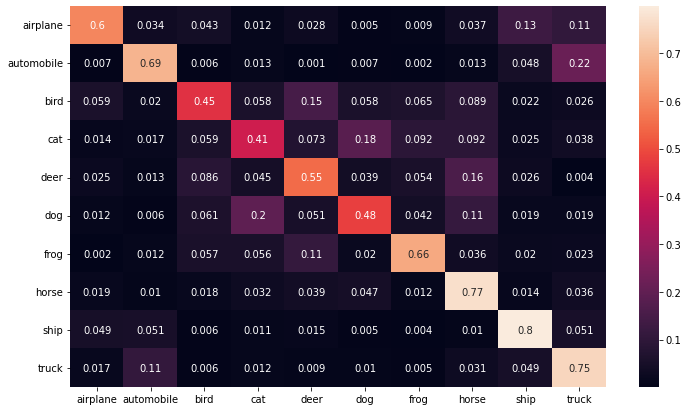

In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        model3.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model3(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = test_data.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

حال در بلاک های زیر یک شبکه عصبی دیگر را تست میکنیم

In [39]:
class Cifar10CnnModel4(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 4 x 4

            nn.Flatten(), 
            nn.Linear(1024*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [40]:
device = ('cuda' if torch.cuda.is_available()
else 'cpu')
model4 = Cifar10CnnModel4().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model4.parameters(),
lr=0.001,
momentum=0.9)

In [41]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
  # Training
  train_loss = 0.0
  model4.train()
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model3(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # Validation
  val_loss = 0.0
  model4.eval()
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model4(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
  print(
  "Epoch: {} Train Loss: {} Val Loss: {}".format(
  epoch,
  train_loss/len(trainloader),
  val_loss/len(valloader)))

Epoch: 0 Train Loss: 1.0922748673915863 Val Loss: 2.3033233306884764
Epoch: 1 Train Loss: 1.0930016973018646 Val Loss: 2.3033223411560058
Epoch: 2 Train Loss: 1.0943052226185799 Val Loss: 2.30332412109375
Epoch: 3 Train Loss: 1.0961288623094558 Val Loss: 2.3033221752166746
Epoch: 4 Train Loss: 1.0947091251730918 Val Loss: 2.3033261276245116
Epoch: 5 Train Loss: 1.09388490588665 Val Loss: 2.3033202018737793
Epoch: 6 Train Loss: 1.095113878238201 Val Loss: 2.3033301467895506
Epoch: 7 Train Loss: 1.0940363361358643 Val Loss: 2.303323020935059
Epoch: 8 Train Loss: 1.094043528020382 Val Loss: 2.3033262573242186
Epoch: 9 Train Loss: 1.0962866977095604 Val Loss: 2.303326142883301


In [42]:
num_correct = 0.0
for x_test_batch, y_test_batch in test_loader:
  model4.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model4(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted ==
    y_test_batch).float().sum()
accuracy = num_correct/(len(test_loader) \
  *test_loader.batch_size)
print(len(test_loader), test_loader.batch_size)
# out: 625 16
print("Test Accuracy: {}".format(accuracy))
# out: Test Accuracy: 0.6322000026702881

625 16
Test Accuracy: 0.09999999403953552


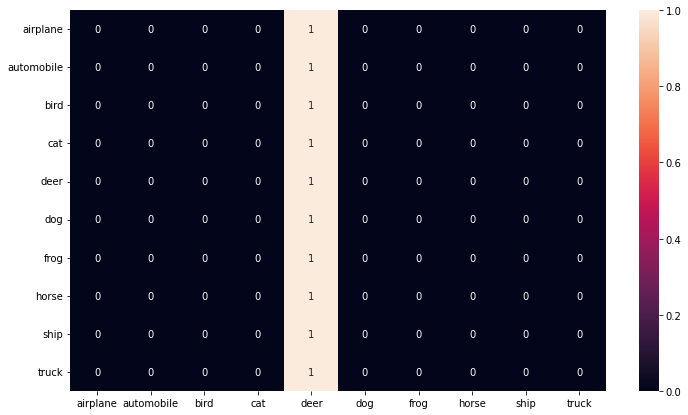

In [43]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        model4.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model4(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = test_data.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

در بلاک های زیرین ما یک شبکه عصبی دیگر را تست میکنیم

In [44]:
class Cifar10CnnModel5(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(), # output: 32 x 34 x 34
            nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 18 x 18

            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), # output: 128 x 20 x 20
            nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 11 x 11

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), # output: 512 x 11 x 11

            nn.Flatten(), 
            nn.Linear(512*11*11, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [45]:
device = ('cuda' if torch.cuda.is_available()
else 'cpu')
model5 = Cifar10CnnModel5().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model5.parameters(),
lr=0.001,
momentum=0.9)

In [46]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
  # Training
  train_loss = 0.0
  model5.train()
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model5(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # Validation
  val_loss = 0.0
  model5.eval()
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model5(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
  print(
  "Epoch: {} Train Loss: {} Val Loss: {}".format(
  epoch,
  train_loss/len(trainloader),
  val_loss/len(valloader)))

Epoch: 0 Train Loss: 1.575237327170372 Val Loss: 1.399166535949707
Epoch: 1 Train Loss: 1.3240835528373718 Val Loss: 1.2474692191123962
Epoch: 2 Train Loss: 1.2141183931827546 Val Loss: 1.1837267007827759
Epoch: 3 Train Loss: 1.1429942407488822 Val Loss: 1.1797367113113404
Epoch: 4 Train Loss: 1.0876488671541213 Val Loss: 1.1301890377044679
Epoch: 5 Train Loss: 1.0402643395900726 Val Loss: 1.0987859469890595
Epoch: 6 Train Loss: 0.999078359425068 Val Loss: 1.0393422112464905
Epoch: 7 Train Loss: 0.9678811446249485 Val Loss: 1.0475885521411896
Epoch: 8 Train Loss: 0.934818960750103 Val Loss: 1.0133812990188598
Epoch: 9 Train Loss: 0.8998939677417278 Val Loss: 1.0036368515968324


In [47]:
num_correct = 0.0
for x_test_batch, y_test_batch in test_loader:
  model5.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model5(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted ==
    y_test_batch).float().sum()
accuracy = num_correct/(len(test_loader) \
  *test_loader.batch_size)
print(len(test_loader), test_loader.batch_size)
# out: 625 16
print("Test Accuracy: {}".format(accuracy))
# out: Test Accuracy: 0.6322000026702881

625 16
Test Accuracy: 0.6620000004768372


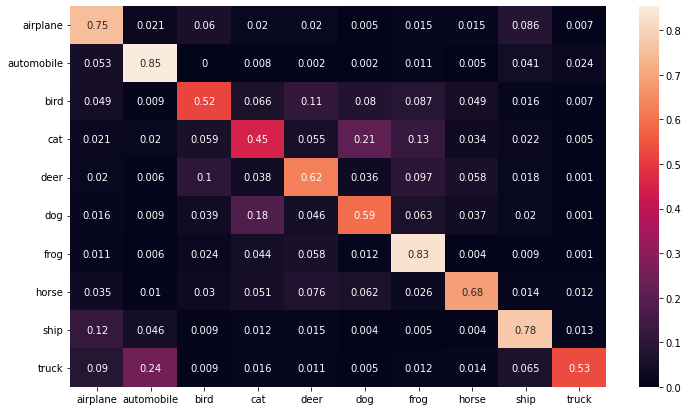

In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        model5.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model5(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = test_data.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

در بلاک های زیر شبکه عصبی دیگری را تست میکنیم

In [49]:
class Cifar10CnnModel6(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1, padding=1),
            nn.BatchNorm2d(32), # output: 32 x 34 x 34
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 18 x 18

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 9 x 9

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3, 3), # output: 256 x 3 x 3

            nn.Flatten(), 
            nn.Linear(256*3*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [50]:
device = ('cuda' if torch.cuda.is_available()
else 'cpu')
model6 = Cifar10CnnModel6().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model6.parameters(),
lr=0.001,
momentum=0.9)

In [51]:
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
  # Training
  train_loss = 0.0
  model6.train()
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model6(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  # Validation
  val_loss = 0.0
  model6.eval()
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model6(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
  print(
  "Epoch: {} Train Loss: {} Val Loss: {}".format(
  epoch,
  train_loss/len(trainloader),
  val_loss/len(valloader)))

Epoch: 0 Train Loss: 1.5315465204000474 Val Loss: 1.2913902678489686
Epoch: 1 Train Loss: 1.19100637819767 Val Loss: 1.047855564403534
Epoch: 2 Train Loss: 1.0299313878417016 Val Loss: 1.0135082576751708
Epoch: 3 Train Loss: 0.9224058426499366 Val Loss: 0.867722089767456
Epoch: 4 Train Loss: 0.8413935406148434 Val Loss: 0.8640952799081802
Epoch: 5 Train Loss: 0.7801416297674179 Val Loss: 0.8184702744245529
Epoch: 6 Train Loss: 0.7310502903401852 Val Loss: 0.7846397027373314
Epoch: 7 Train Loss: 0.6884464762434364 Val Loss: 0.7280995262622834
Epoch: 8 Train Loss: 0.6524218491822481 Val Loss: 0.756588478565216
Epoch: 9 Train Loss: 0.6185785198271274 Val Loss: 0.6852199841737747


In [52]:
num_correct = 0.0
for x_test_batch, y_test_batch in test_loader:
  model6.eval()
  y_test_batch = y_test_batch.to(device)
  x_test_batch = x_test_batch.to(device)
  y_pred_batch = model6(x_test_batch)
  _, predicted = torch.max(y_pred_batch, 1)
  num_correct += (predicted ==
    y_test_batch).float().sum()
accuracy = num_correct/(len(test_loader) \
  *test_loader.batch_size)
print(len(test_loader), test_loader.batch_size)
# out: 625 16
print("Test Accuracy: {}".format(accuracy))
# out: Test Accuracy: 0.6322000026702881

625 16
Test Accuracy: 0.7750999927520752


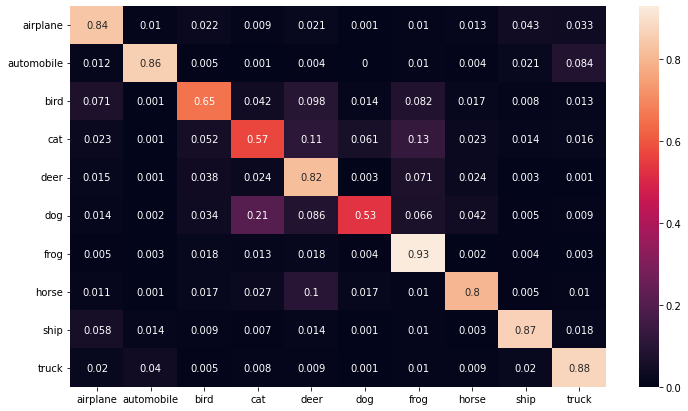

In [53]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        model6.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model6(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = test_data.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')